#  迁移学习

In [32]:
import os
import shutil
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.applications import *
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np

In [37]:
#参数

train_file_name='train'
valid_file_name='valid'
IM_WIDTH, IM_HEIGHT = 299, 299 #fixed size for InceptionV3
batch_size=128

nb_epoch =1
FC_SIZE = 1024

In [34]:
#图片分类，创建软链接
train_filenames = os.listdir('imagedata/train')
test_filenames = os.listdir('imagedata/test')
valid_count=int(len(train_filenames)*0.1)

valid_data=train_filenames[-valid_count:]
train_data=train_filenames[:-valid_count]

train_cat = filter(lambda x:x[:3] == 'cat', train_data)
train_dog = filter(lambda x:x[:3] == 'dog', train_data)

valid_cat = filter(lambda x:x[:3] == 'cat', valid_data)
valid_dog = filter(lambda x:x[:3] == 'dog', valid_data)

def cre_rem_dir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

cre_rem_dir(train_file_name)
os.mkdir(train_file_name+'/cat')
os.mkdir(train_file_name+'/dog')

cre_rem_dir(valid_file_name)
os.mkdir(valid_file_name+'/cat')
os.mkdir(valid_file_name+'/dog')

cre_rem_dir('test')
cur_path=os.getcwd()

for filename in train_cat:
    os.symlink(cur_path+'/imagedata/train/'+filename, train_file_name+'/cat/'+filename)
for filename in train_dog:
    os.symlink(cur_path+'/imagedata/train/'+filename, train_file_name+'/dog/'+filename)
for filename in valid_cat:
    os.symlink(cur_path+'/imagedata/train/'+filename, valid_file_name+'/cat/'+filename)
for filename in valid_dog:
    os.symlink(cur_path+'/imagedata/train/'+filename, valid_file_name+'/dog/'+filename)
for filename in test_filenames:
    os.symlink(cur_path+'/imagedata/test/'+filename, 'test/'+filename)


In [35]:
#数据增强
train_datagen =  ImageDataGenerator(
    preprocessing_function=inception_v3.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=inception_v3.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


train_generator = train_datagen.flow_from_directory(
  'train',
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=batch_size,
)
validation_generator = valid_datagen.flow_from_directory(
  'valid',
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=batch_size,
)


Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [36]:
base_model = InceptionV3(weights='imagenet', include_top=False)

#添加新层
def add_new_last_layer(base_model, nb_classes):
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x) 
    predictions = Dense(nb_classes, activation='softmax')(x) 
    model = Model(input=base_model.input, output=predictions)
    return model


def setup_to_transfer_learn(model, base_model):
    for layer in base_model.layers:
        layer.trainable = False
        model.compile(optimizer='rmsprop',
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

        
model=add_new_last_layer(base_model,2)

setup_to_transfer_learn(model,base_model)

/Users/hl/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
history = model.fit_generator(
  train_generator,
  nb_epoch=nb_epoch,
  validation_data=validation_generator,
  class_weight='auto')
model.save('inceptionV3')

/Users/hl/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/Users/hl/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., epochs=1, class_weight="auto")`
  """


Epoch 1/1
 13/176 [=>............................] - ETA: 3:05:12 - loss: 1.9482 - acc: 0.6310

In [5]:
#可视化

def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
  
    plt.show()

plot_training(history)    

NameError: name 'history' is not defined

In [ ]:
# #预测函数
# def predict(model, img, target_size):
    
#     if img.size != target_size:   
#         img = img.resize(target_size)

#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)
#     preds = model.predict(x)
#     return preds[0]

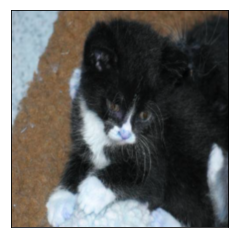

(299, 299, 3)
9733.jpg


In [19]:
img_id=0

plt.imshow(test_image[img_id],cmap='gray',interpolation = 'bicubic')
plt.xticks([]),plt.yticks([])
plt.show()

print(test_image[img_id].shape)
print(number_list[img_id])

In [31]:
def predict(model, img, target_size):

    if img.size != target_size:
        img = img.resize(target_size)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


#读取测试图片
path='/imagedata/test'
test_image=[]
number_list=[]
current_path=os.getcwd()
abosult_path=current_path+path
for image_name in os.listdir(abosult_path):
    img = Image.open(current_path+"/"+image_name)
    
    
    predict(model,img,(299,299))
    
    
#     number_list.append(image_name)
#     img =cv2.imread(abosult_path+'/'+image_name,1)
#     img_resize=cv2.resize(img,(299,299))
#     test_image.append(img_resize)


          id  label
0          1    0.5
1          2    0.5
2          3    0.5
3          4    0.5
4          5    0.5
5          6    0.5
6          7    0.5
7          8    0.5
8          9    0.5
9         10    0.5
10        11    0.5
11        12    0.5
12        13    0.5
13        14    0.5
14        15    0.5
15        16    0.5
16        17    0.5
17        18    0.5
18        19    0.5
19        20    0.5
20        21    0.5
21        22    0.5
22        23    0.5
23        24    0.5
24        25    0.5
25        26    0.5
26        27    0.5
27        28    0.5
28        29    0.5
29        30    0.5
...      ...    ...
12470  12471    0.5
12471  12472    0.5
12472  12473    0.5
12473  12474    0.5
12474  12475    0.5
12475  12476    0.5
12476  12477    0.5
12477  12478    0.5
12478  12479    0.5
12479  12480    0.5
12480  12481    0.5
12481  12482    0.5
12482  12483    0.5
12483  12484    0.5
12484  12485    0.5
12485  12486    0.5
12486  12487    0.5
12487  12488    0.5


NameError: name 'model' is not defined